# Auto Encoders and VAEs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

## Load digits

In [ ]:
DATA_PATH = '../data/'

In [2]:
# import MNIST data
digits = datasets.MNIST(DATA_PATH, train=True, download=True, transform=transforms.ToTensor())

In [69]:
digit_values = digits.data
digit_labels = digits.targets

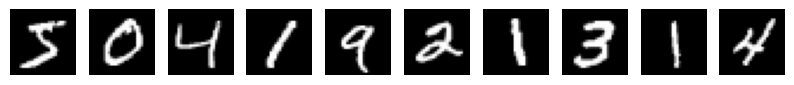

In [4]:


fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(digit_values[i], cmap='gray')
    axs[i].axis('off')

plt.show()

In [70]:
# split data into training and validation sets


train_values, val_values, train_labels, val_labels = train_test_split(digit_values, digit_labels, test_size=0.1)

We make a custom dataset and a function to add noise to the digits

In [71]:
class NoisyMNIST(Dataset):
    def __init__(self, x, transform=None):
        self.image = x/255.0
        self.label = x.clone()/255.0
        self.transform = transform

    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, idx):
        image = self.image[idx]
        label = self.label[idx]
        image = np.array(image)
        if self.transform:
            image = self.transform(image)
        # make sure floats
        return image.float(), label.float()


In [72]:
def add_noise(x, noise_factor):  # Random noise factor between 0 and 0.5
    noisy_x = x + noise_factor * torch.randn(x.size())
    noisy_x = torch.clip(noisy_x, 0., 1.)
    return noisy_x

In [73]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = NoisyMNIST(train_values, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = NoisyMNIST(val_values, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Plot some digits with added noise to see what they look like.

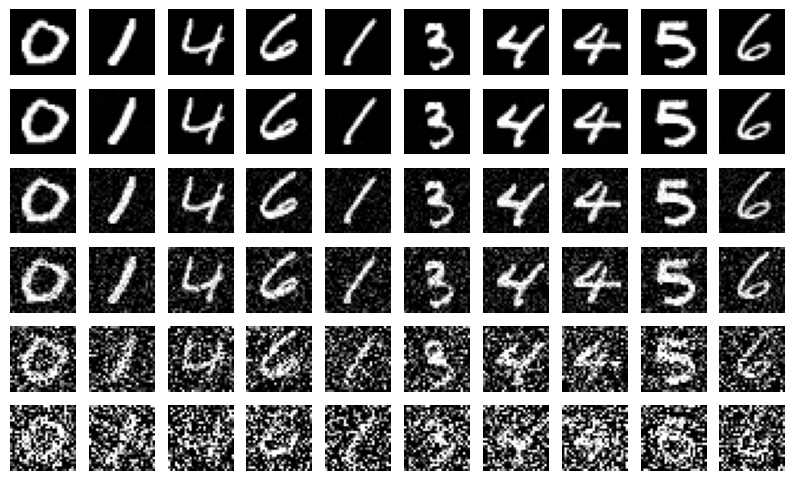

In [30]:
sample_x = train_dataset.image[:10]

eps = [0, 0.01, 0.1, 0.2, 0.5, 0.8]

fig, axs = plt.subplots(6, 10, figsize=(10, 6))
for i, e in enumerate(eps):
    for j in range(10):
        axs[i, j].imshow(add_noise(sample_x[j], e).numpy(), cmap='gray')
        axs[i, j].axis('off')

## Auto Encoder
This is a really simple auto encoder. It's simple because it is entirely composed of linear layers. We reduce dimensionality of the data from 784 dimensions down to only 8!

In [44]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 8),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28*28),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

In [45]:
img, _ = next(iter(train_loader))
model = Autoencoder()

noisy_img = add_noise(img, 0.5)
print(noisy_img.shape)
print(img.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


In [46]:
BATCH_SIZE = 32

model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

train_loss = []
test_loss = []

for epoch in range(n_epochs):
    model.train()
    train_losses = []
    for img, _ in train_loader:
        # random noise factor between 0 and 1
        noise_factor = np.random.rand()
        noisy_img = add_noise(img, noise_factor)
        img = img.view(-1, 28*28)
        noisy_img = noisy_img.view(-1, 28*28)
        optimizer.zero_grad()
        outputs = model(noisy_img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss.append(np.mean(train_losses))

    model.eval()
    test_losses = []
    for img, _ in test_loader:
        noise_factor = np.random.rand()
        noisy_img = add_noise(img, noise_factor)
        img = img.view(-1, 28*28)
        noisy_img = noisy_img.view(-1, 28*28)
        outputs = model(noisy_img)
        loss = criterion(outputs, img)
        test_losses.append(loss.item())
    test_loss.append(np.mean(test_losses))

    print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}')

Epoch 1, Train Loss: 0.052680571854856056, Test Loss: 0.0396317235055439
Epoch 2, Train Loss: 0.03673409438864173, Test Loss: 0.03414097792924719
Epoch 3, Train Loss: 0.033251145268653595, Test Loss: 0.03289229290044688
Epoch 4, Train Loss: 0.031628670085936575, Test Loss: 0.030826353576985446
Epoch 5, Train Loss: 0.030286826364369402, Test Loss: 0.029173960899339713
Epoch 6, Train Loss: 0.02948730324959974, Test Loss: 0.029261866188112724
Epoch 7, Train Loss: 0.028830399073580926, Test Loss: 0.028563161261696765
Epoch 8, Train Loss: 0.028511112931038814, Test Loss: 0.028158309106576317
Epoch 9, Train Loss: 0.02823560505275619, Test Loss: 0.028318748066320697
Epoch 10, Train Loss: 0.027962082158332752, Test Loss: 0.027852264411271886


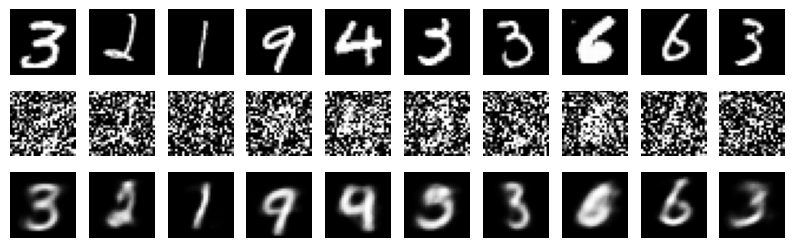

In [51]:
# 10 random integers
idx = np.random.randint(0, len(test_dataset), 10)
sample_x = train_dataset.image[idx]
sample_x_noisy = add_noise(sample_x, 1.0)

fig, axs = plt.subplots(3, 10, figsize=(10, 3))
for i in range(10):
    axs[0, i].imshow(sample_x[i], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(sample_x_noisy[i], cmap='gray')
    axs[1, i].axis('off')
    axs[2, i].imshow(model(sample_x_noisy[i].view(1, -1).float()).detach().numpy().reshape(28, 28), cmap='gray')
    axs[2, i].axis('off')

Considering, I can't really tell what any of those numbers are on the middle line, that's not terrible.

### Latent space visualization

In [52]:
encoder = model.encoder
decoder = model.decoder

In [53]:
digit_sample = digit_values[:10000]/255.0
label_sample = digit_labels[:10000]

In [54]:
latent = encoder(digit_sample)

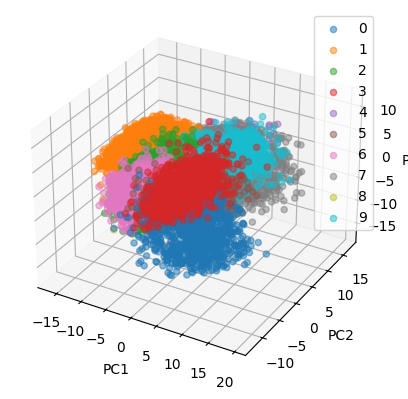

In [59]:
# pca
pca = PCA(n_components=3)
pca.fit(latent.detach().numpy())
latent_pca = pca.transform(latent.detach().numpy())

# 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    ax.scatter(latent_pca[label_sample == i, 0], latent_pca[label_sample == i, 1], latent_pca[label_sample == i, 2], label=str(i), alpha=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.show()

Let's try to "generate" some samples by drawing random numbers from the latent space.

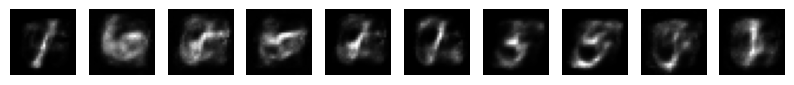

In [62]:
# sample some values from latent space
n = 10
x = torch.randn(n, 8)
x = decoder(x)

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(x[i].detach().numpy().reshape(28, 28), cmap='gray')
    axs[i].axis('off')

plt.show()

That looks pretty terrible, but you can sort of make out some digits...if you kind of squint.

# VAE

In [84]:
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [85]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 16)
        # Decoder
        self.fc4 = nn.Linear(8, 32)
        self.fc5 = nn.Linear(32, 128)
        self.fc6 = nn.Linear(128, 784)

    def encode(self, x):
        h1 = nn.functional.gelu(self.fc1(x))
        h2 = nn.functional.gelu(self.fc2(h1))
        h3 = nn.functional.gelu(self.fc3(h2))

        mu, logvar = torch.chunk(h3, 2, dim=1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h4 = nn.functional.gelu(self.fc4(z))
        h5 = nn.functional.gelu(self.fc5(h4))
        return torch.sigmoid(self.fc6(h5))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [86]:
BATCH_SIZE = 32

model = VAE()
# criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

train_loss = []
test_loss = []

for epoch in range(n_epochs):
    model.train()
    train_losses = []
    for img, _ in train_loader:
        # random noise factor between 0 and 1
        noise_factor = np.random.rand()
        noisy_img = add_noise(img, noise_factor)
        img = img.view(-1, 28*28)
        noisy_img = noisy_img.view(-1, 28*28)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(noisy_img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss.append(np.mean(train_losses))

    model.eval()
    test_losses = []
    for img, _ in test_loader:
        noise_factor = np.random.rand()
        noisy_img = add_noise(img, noise_factor)
        img = img.view(-1, 28*28)
        noisy_img = noisy_img.view(-1, 28*28)
        recon_batch, mu, logvar = model(noisy_img)
        loss = loss_function(recon_batch, img, mu, logvar)
        test_losses.append(loss.item())
    test_loss.append(np.mean(test_losses))

    print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}')

Epoch 1, Train Loss: 1680.4123762230172, Test Loss: 1532.3934985221701
Epoch 2, Train Loss: 1445.5520720278482, Test Loss: 1392.1129192595786
Epoch 3, Train Loss: 1367.4601778509493, Test Loss: 1335.3701003054355
Epoch 4, Train Loss: 1326.3851634021055, Test Loss: 1309.4923559959898
Epoch 5, Train Loss: 1305.5231693502851, Test Loss: 1286.9415753953
Epoch 6, Train Loss: 1291.103003190027, Test Loss: 1273.483315975108
Epoch 7, Train Loss: 1281.2065172602215, Test Loss: 1281.6253093962973
Epoch 8, Train Loss: 1273.1758811914526, Test Loss: 1262.9156636988862
Epoch 9, Train Loss: 1270.8584835902209, Test Loss: 1266.3859593817529
Epoch 10, Train Loss: 1268.814804438731, Test Loss: 1264.255149678981


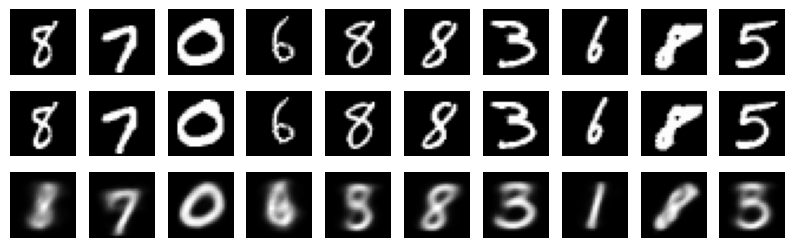

In [88]:
# 10 random integers
idx = np.random.randint(0, len(test_dataset), 10)
sample_x = train_dataset.image[idx]
sample_x_noisy = add_noise(sample_x, 0.0)

fig, axs = plt.subplots(3, 10, figsize=(10, 3))
for i in range(10):
    axs[0, i].imshow(sample_x[i], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(sample_x_noisy[i], cmap='gray')
    axs[1, i].axis('off')
    recon_batch, mu, logvar = model(sample_x_noisy[i].view(1, -1).float())
    axs[2, i].imshow(recon_batch.detach().numpy().reshape(28, 28), cmap='gray')
    axs[2, i].axis('off')

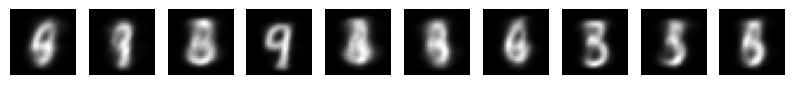

In [89]:
n = 10
x = torch.randn(n, 8)
x = model.decode(x)

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(x[i].detach().numpy().reshape(28, 28), cmap='gray')
    axs[i].axis('off')

plt.show()

In [90]:
# look at latent space of digit_sample
encoder = model.encode
# must use digit_sample
latent = encoder(digit_sample.view(-1, 784))[0]

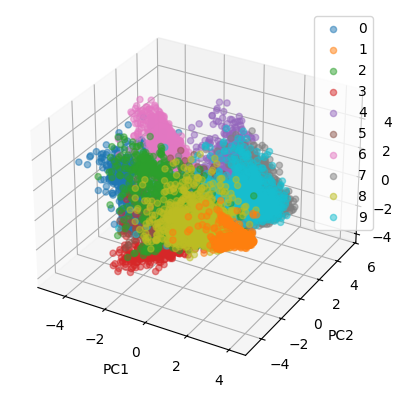

In [91]:
# pca
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(latent.detach().numpy())
latent_pca = pca.transform(latent.detach().numpy())

# 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    ax.scatter(latent_pca[label_sample == i, 0], latent_pca[label_sample == i, 1], latent_pca[label_sample == i, 2], label=str(i), alpha=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.show()